In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from collections import OrderedDict
from multiprocessing import Pool
from numba import jit
from tqdm.auto import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa import arima_process
from statsmodels.tsa.statespace.tools import (
    constrain_stationary_univariate, unconstrain_stationary_univariate)


sns.set_context("paper", font_scale=1.7)
sns.set_style(
    "ticks",
    {
        "axes.grid": True,
        "grid.color": "0.95",
        "grid.linestyle": "-",
        "axes.facecolor": "white",
        "figure.facecolor": "#FAFAFA",
    },
)

# Import Data

In [2]:
%%time
data_files = glob.glob("../data/returns/ticker_daily_rv/*.feather")

ticker_dfs = []
for ticker_df in tqdm(map(pd.read_feather, data_files), total = len(data_files)):
    ticker_dfs.append(ticker_df)

data_rv_df = pd.concat(ticker_dfs).reset_index(drop = True)


CPU times: user 2.88 s, sys: 3.41 s, total: 6.28 s
Wall time: 7.54 s


# Clean Data

## Additional Vars

In [3]:
data_rv_df['1'] = 1
data_rv_df['rvol'] = np.sqrt(data_rv_df['rv'])

## Lagged Measures

In [4]:
data_rv_df = data_rv_df.sort_values(by = ['ticker', 'date'])

# Signed Jump variants
data_rv_df['sgn_jump_var_pos'] = data_rv_df['sgn_jump_var']*(data_rv_df['sgn_jump_var'] > 0)
data_rv_df['sgn_jump_var_neg'] = data_rv_df['sgn_jump_var']*(data_rv_df['sgn_jump_var'] < 0)

data_rv_df['rq'] = data_rv_df['return_p4']/3
data_rv_df['sqrt_rq'] = np.sqrt(data_rv_df['rq'])

data_rv_df['year'] = data_rv_df['date'].dt.year

In [5]:
# Lags
data_rv_df["rv_d_lag_1"] = data_rv_df["return_d_p2"].shift(1)
data_rv_df["rv_d_lag_m5"] = data_rv_df["rv_lag_1"].rolling(5).mean()
data_rv_df["rv_d_lag_m22"] = data_rv_df["rv_lag_1"].rolling(22).mean()

In [6]:
lag_coeff_cols = [
    "return_j_pos",
    "return_j_neg",
    "return_d_pos",
    "return_d_neg",
    "sum_jump_p2_1",
    "sum_jump_p2_5",
    "sum_jump_p2_22",
    "sum_jump_p2_pos_1",
    "sum_jump_p2_pos_5",
    "sum_jump_p2_pos_22",
    "sum_jump_p2_neg_1",
    "sum_jump_p2_neg_5",
    "sum_jump_p2_neg_22",
    "sgn_jump_var",
    "sgn_jump_var_pos",
    "sgn_jump_var_neg",
    "sqrt_rq",
]

interact_cols = [
    "rv_lag_1",
    "rv_lag_m5",
    "rv_lag_m22",
    "rv_d_lag_1",
    "rv_d_lag_m5",
    "rv_d_lag_m22",
]

for col in tqdm(lag_coeff_cols):
    data_rv_df[col + "_lag_1"] = data_rv_df.groupby("ticker")[col].shift(1)

    for icol in interact_cols:
        data_rv_df[f"{icol}:{col}_lag_1"] = np.multiply(
            data_rv_df[icol], data_rv_df[col + "_lag_1"]
        )

# Rolling Beta

In [7]:
# Window length
window = 66

# Regression
reg_formula = 'rv ~ rv_lag_1 + rv_lag_m5 + rv_lag_m22'
var_list = reg_formula.replace('+', ' ').replace('~', ' ').split()

In [8]:
def fit_rolling_regression(ticker):

    reg_df = (
        data_rv_df.query("ticker == @ticker")
        .sort_values(by="date")[["date"] + var_list]
        .dropna()
        .set_index('date')
    )
    fit = RollingOLS.from_formula(reg_formula, reg_df, window).fit(
        method="pinv", params_only=True
    )

    fit_params_df = fit.params
    fit_params_df["ticker"] = ticker

    return fit_params_df.reset_index()

In [9]:
%%time
# Run HARs
tickers = data_rv_df[
    "ticker"
].unique()  
results = []

with Pool(8) as p:
    for fit_params_df in tqdm(
        p.imap_unordered(fit_rolling_regression, tickers, chunksize=30),
        total=len(tickers),
    ):
        results.append(fit_params_df)

rolling_beta_df = pd.concat(results)


CPU times: user 969 ms, sys: 1.44 s, total: 2.41 s
Wall time: 1min 8s


In [10]:
coeff_cols = ["rv_lag_1", "rv_lag_m5", "rv_lag_m22"]
data_rv_df = data_rv_df.merge(
    rolling_beta_df.rename(columns={x: (x + "_rollcoeff") for x in coeff_cols}).drop(
        "Intercept", axis=1
    ),
    on=["date", "ticker"], how = 'left'
)

<AxesSubplot:xlabel='date'>

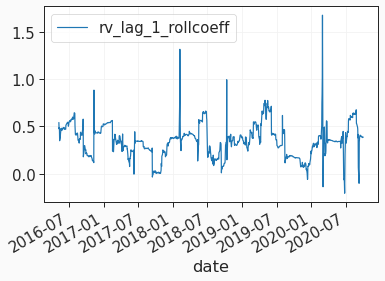

In [11]:
data_rv_df.query('ticker == "AAPL"').plot(x = 'date', y = 'rv_lag_1_rollcoeff')

# Forecast Analysis

## Forecast Funcs

In [12]:
from numba.core.errors import NumbaPerformanceWarning
import warnings

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)

## Numba functions, about 90 times faster than usual ones
@jit(nopython = True)
def numba_ols(y, x):
    beta_hat = np.linalg.pinv(x.T @ x) @ (x.T @ y)
    return beta_hat

# Compile by running on some random data
numba_ols(np.random.normal(0,1,(100,1)), np.random.normal(0,1,(100,3)));

In [16]:
def get_forecast_error_ols(ticker_rv_df, endog_vars, exog_vars, window, skip_rows = 25):

    # Set up regression dataframe
    exog_vars = [x.strip() for x in exog_vars.replace('\n', '').split('+')]
    reg_data_df = ticker_rv_df[[endog_vars] + exog_vars].iloc[(skip_rows-1):,:].reset_index(drop = True)

    if np.any(reg_data_df.isna()):
        print(np.any(reg_data_df.isna(), axis = 0))
        raise Exception('NA Values in reg data')

    end_index = len(reg_data_df)
    reg_data_array = reg_data_df.values
    forecast_loss_array = []

    is_switch_estimator = 'switch' in ''.join(exog_vars)
    is_jump_estimator = 'jump' in ''.join(exog_vars)
    
    for i in range(0, end_index-window+1):

        reg_data_array_splice = np.asfortranarray(reg_data_array[i:(i+window),:])

        # Regress on winow-1 observations
        train_endog, train_exog = reg_data_array_splice[:(window-1),0], reg_data_array_splice[:(window-1),1:]

        # Testing observations
        test_endog, test_exog = reg_data_array_splice[-1,0], reg_data_array_splice[-1,1:]

        # Regress and get forecast error
        forecast = test_exog @ numba_ols(train_endog, train_exog) 
        if is_switch_estimator or is_jump_estimator:
            forecast = np.max([np.min(train_endog), forecast])
            forecast = np.min([np.max(train_endog), forecast])
        forecast_loss = np.square(test_endog - forecast)
        forecast_loss_array.append(forecast_loss)
        
    return forecast_loss_array

## Set up switch

In [17]:
data_rv_df["persistence"] = (
    data_rv_df["rv_lag_1_rollcoeff"]
    + data_rv_df["rv_lag_m5_rollcoeff"]
    + data_rv_df["rv_lag_m22_rollcoeff"]
)


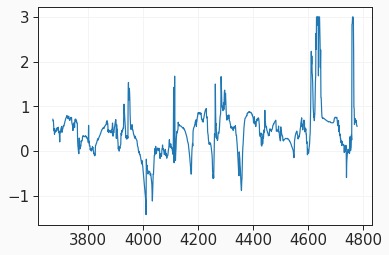

In [18]:
plt.plot(data_rv_df.query('ticker == "AAPL"')['persistence'].clip(-3, 3))

In [59]:
data_rv_df["indicator_high_beta"] = data_rv_df["persistence"].clip(-3, 3) > 0.5
# data_rv_df["indicator_high_beta"] = data_rv_df["rv_lag_1_rollcoeff"] > 0.5
data_rv_df["switch"] = (
    data_rv_df.groupby("ticker")["indicator_high_beta"]
    .rolling(22)
    .mean()
    .reset_index(drop=True)
)
data_rv_df["switch_lag_1"] = (
    data_rv_df.groupby("ticker")["switch"].shift(1).reset_index(drop=True)
)

In [60]:
data_rv_df['switchn'] = 1 - data_rv_df['switch']
data_rv_df['switchn_lag_1'] = 1 - data_rv_df['switch_lag_1']

interact_cols = [
    'rv_lag_1',
    'rv_lag_m5',
    'rv_lag_m22',
    'rv_d_lag_1',
    'rv_d_lag_m5',
    'rv_d_lag_m22',
]

for col in tqdm(interact_cols):
    data_rv_df[f'{col}:switchn_lag_1'] = data_rv_df[col]*data_rv_df['switchn_lag_1']

## Performance

In [83]:
# Params
window = 250
skip_rows = 25
endog_vars = 'rv'

In [95]:
exog_vars_list = [
'''
1+ rv_lag_1
''',
'''
1 + rv_lag_1
+ rv_lag_m5
+ rv_lag_m22
''',
'''
1 + rv_lag_1
+ rv_lag_1:sqrt_rq_lag_1
+ rv_lag_m5
+ rv_lag_m22
''',
'''
1 + rv_lag_1
+ rv_lag_1:sum_jump_p2_1_lag_1
+ rv_lag_m5
+ rv_lag_m5:sum_jump_p2_5_lag_1
+ rv_lag_m22
+ rv_lag_m22:sum_jump_p2_22_lag_1
''',
'''
1 + rv_lag_1
+ rv_lag_1:sum_jump_p2_pos_1_lag_1
+ rv_lag_1:sum_jump_p2_neg_1_lag_1
+ rv_lag_m5
+ rv_lag_m5:sum_jump_p2_pos_5_lag_1
+ rv_lag_m5:sum_jump_p2_neg_5_lag_1
+ rv_lag_m22
+ rv_lag_m22:sum_jump_p2_pos_22_lag_1
+ rv_lag_m22:sum_jump_p2_neg_22_lag_1
''',
# '''
# 1 + rv_lag_1
# + rv_lag_1:sum_jump_p2_pos_1_lag_1
# + rv_lag_1:sum_jump_p2_neg_1_lag_1
# + rv_lag_m5
# + rv_lag_m5:sum_jump_p2_pos_5_lag_1
# + rv_lag_m5:sum_jump_p2_neg_5_lag_1
# + rv_lag_m22
# + rv_lag_m22:sum_jump_p2_pos_22_lag_1
# + rv_lag_m22:sum_jump_p2_neg_22_lag_1
# ''',
'''
1 + switchn_lag_1 
+ rv_lag_1 + rv_lag_1:switchn_lag_1 + 
rv_lag_m5:switchn_lag_1 + rv_lag_m22:switchn_lag_1
''',
'''
1 + switchn_lag_1 
+ rv_lag_1 + rv_lag_1:switchn_lag_1 + 
rv_lag_m5 + rv_lag_m5:switchn_lag_1 + 
rv_lag_m22 + rv_lag_m22:switchn_lag_1
''',
# '''
# 1 + switchn 
# + rv_lag_1 + rv_lag_1:switchn_lag_1 + 
# rv_lag_m5:switchn_lag_1 + rv_lag_m22:switchn_lag_1
# + rv_lag_1:sum_jump_p2_pos_1_lag_1
# + rv_lag_1:sum_jump_p2_neg_1_lag_1
# ''',
# '''
# 1 
# + rv_lag_1 + rv_lag_1:switchn_lag_1 
# + rv_lag_m5 + rv_lag_m5:switchn_lag_1 
# + rv_lag_m22 + rv_lag_m22:switchn_lag_1
# ''',
]

In [96]:
data_tickers_rv_df = data_rv_df.set_index('ticker').copy()
ticker_list = list(data_tickers_rv_df.index.unique())

In [97]:
def temp_f(ticker):

    ticker_rv_df = data_tickers_rv_df.loc[ticker, :]
        
    forecast_loss_list = []
    for exog_vars in exog_vars_list:
        
        try:
            forecast_loss = (
                get_forecast_error_ols(ticker_rv_df, endog_vars, exog_vars, window)
            )
        except:
            raise Exception(f'Issue with {ticker} and\n{exog_vars}')
        forecast_loss_list.append(forecast_loss)
        
    return [ticker] + [forecast_loss_list]

In [98]:
%%time
ols_reg_results = []

with Pool(8) as p:

    for result in tqdm(
        p.imap_unordered(temp_f, ticker_list), total=len(ticker_list)
    ):
        ols_reg_results.append(result)


CPU times: user 1.69 s, sys: 2.34 s, total: 4.03 s
Wall time: 48.7 s


In [99]:
# Formatted results
reg_names = [
    'simple',
    'har', 
    'harq', 
    'har_j2', 
    'har_posneg_j2', 
    'har_ls',
    'har_ls_extend'
]

results_df = pd.DataFrame(ols_reg_results, columns = ['ticker', 'forecast_error_results']).set_index('ticker')

results_df["forecast_error_means"] = (
    results_df["forecast_error_results"]
    .apply(lambda x: np.mean(np.array(x), axis=1))
    .values
)
results_df["forecast_error_medians"] = (
    results_df["forecast_error_results"]
    .apply(lambda x: np.median(np.array(x), axis=1))
    .values
)

results_df[[x + '_mean' for x in reg_names]] = results_df['forecast_error_means'].apply(pd.Series)
results_df[[x + '_median' for x in reg_names]] = results_df['forecast_error_medians'].apply(pd.Series)

results_df = results_df.reset_index()
results_df

ticker                             forecast_error_results  \
0      AAL  [[4.953998971600094e-09, 1.5888014450111132e-0...   
1      ABT  [[3.718308476448075e-10, 1.7407497601951514e-1...   
2     ABMD  [[8.263170190487989e-10, 7.929060116615668e-09...   
3     AAPL  [[8.817014352944507e-10, 1.8615674893394485e-0...   
4     ABBV  [[3.6849271303647972e-09, 5.525682679416593e-0...   
..     ...                                                ...   
466    XRX  [[9.732876183232126e-12, 2.3923722630429302e-0...   
467    ZBH  [[7.94035578299443e-11, 4.063778109995029e-09,...   
468   ZBRA  [[1.8086510554541116e-09, 1.3179865110762408e-...   
469    ZTS  [[6.440562290128957e-10, 2.6662213580816372e-0...   
470   ZION  [[1.4292133451829744e-08, 2.725751813801029e-0...   

                                  forecast_error_means  \
0    [2.9039620318899475e-06, 3.426262587850588e-06...   
1    [8.80360944247376e-08, 1.061479389552356e-07, ...   
2    [4.011215809947638e-07, 3.7390011726566403e-07...   
3    [1.1764604606899776e-07, 1.2657199713299428e-0...   
4    [1.0876366449210464e-07, 1.2128808641144757e-0...   
..                                                 ...   
466  [4.1228312458699197e-07, 5.469178861418833e-07...   
467  [4.019643698519703e-07, 3.534697826286328e-07,...   
468  [1.9504742767959296e-07, 1.9327853654714668e-0...   
469  [1.3392252735263872e-07, 1.7625056276410353e-0...   
470  [7.114428990280031e-08, 7.13598577603142e-08, ...   

                                forecast_error_medians   simple_mean  \
0    [1.2142855911151138e-08, 1.0898817472053554e-0...  2.903962e-06   
1    [1.060622517350359e-09, 9.646241703092556e-10,...  8.803609e-08   
2    [1.779364544292881e-08, 1.6139793886236763e-08...  4.011216e-07   
3    [1.925360977740507e-09, 1.5182095244831436e-09...  1.176460e-07   
4    [4.515584297350479e-09, 3.450423710654814e-09,...  1.087637e-07   
..                                                 ...           ...   
466  [6.277723512493206e-09, 5.137211487352236e-09,...  4.122831e-07   
467  [1.9840431651040056e-09, 1.8977851191089016e-0...  4.019644e-07   
468  [1.074806070170865e-08, 9.511350883508964e-09,...  1.950474e-07   
469  [1.393414170137658e-09, 1.1839431957417418e-09...  1.339225e-07   
470  [3.0813391074920173e-09, 2.860870016198644e-09...  7.114429e-08   

         har_mean     harq_mean   har_j2_mean  har_posneg_j2_mean  \
0    3.426263e-06  5.376691e-06  4.238007e-06        4.148287e-06   
1    1.061479e-07  1.101543e-07  1.108592e-07        1.061980e-07   
2    3.739001e-07  3.589184e-07  4.370610e-07        4.410502e-07   
3    1.265720e-07  1.998199e-07  1.348260e-07        1.426235e-07   
4    1.212881e-07  1.512970e-07  1.360609e-07        1.494322e-07   
..            ...           ...           ...                 ...   
466  5.469179e-07  1.856011e-06  8.010904e-07        7.032272e-07   
467  3.534698e-07  4.072714e-05  3.040426e-07        3.377474e-07   
468  1.932785e-07  1.812258e-07  2.609952e-07        3.240541e-07   
469  1.762506e-07  2.027773e-07  1.294029e-07        1.407815e-07   
470  7.135986e-08  1.053520e-07  8.385709e-08        1.023459e-07   

      har_ls_mean  har_ls_extend_mean  simple_median    har_median  \
0    2.910185e-06        3.588425e-06   1.214286e-08  1.089882e-08   
1    9.022665e-08        1.038875e-07   1.060623e-09  9.646242e-10   
2    3.536330e-07        3.741698e-07   1.779365e-08  1.613979e-08   
3    1.265609e-07        1.450826e-07   1.925361e-09  1.518210e-09   
4    1.086408e-07        1.529799e-07   4.515584e-09  3.450424e-09   
..            ...                 ...            ...           ...   
466  3.915433e-07        4.837872e-07   6.277724e-09  5.137211e-09   
467  1.785026e-07        3.152899e-07   1.984043e-09  1.897785e-09   
468  1.562257e-07        1.671809e-07   1.074806e-08  9.511351e-09   
469  1.094613e-07        1.424115e-07   1.393414e-09  1.183943e-09   
470  6.746152e-08        6.827067e-08   3.081339e-09  2.860870

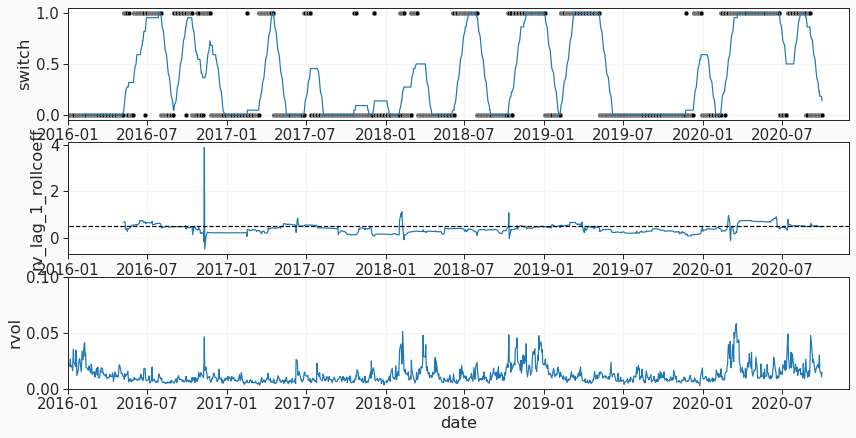

In [100]:
fig, axs = plt.subplots(nrows=3, figsize=(14, 7))
ticker = "AMZN"
sns.lineplot(
    x="date", y="switch", data=data_rv_df.query("ticker == @ticker"), ax=axs[0]
)
sns.scatterplot(
    x="date",
    y="indicator_high_beta",
    color="k",
    data=data_rv_df.query("ticker == @ticker"),
    ax=axs[0],
)

ax = axs[1]
sns.lineplot(
    x="date", y="rv_lag_1_rollcoeff", data=data_rv_df.query("ticker == @ticker"), ax=ax
)
ax.axhline(0.5, -1, 1, color = 'k', ls = 'dashed')

ax  = axs[2]
sns.lineplot(
    x="date", y="rvol", data=data_rv_df.query("ticker == @ticker"), ax=ax
)
ax.axhline(0.5, -1, 1, color = 'k', ls = 'dashed')
ax.set_ylim(0, 0.1)

for ax in axs.reshape(-1):
    ax.set_xlim(pd.to_datetime('2016-01-01'), pd.to_datetime('2020-12-01'))

In [101]:
reg_formulas_fmt = [x.replace('\n', ' ').strip() for x in exog_vars_list]

In [102]:
pd.DataFrame(
    results_df[[x for x in results_df.columns if "mean" in x]].mean() * 1e6
).style.background_gradient(cmap=matplotlib.cm.viridis_r)

In [103]:
#results_df[[x for x in results_df.columns if 'median' in x]].mean()[1:]*1e6

In [104]:
pd.DataFrame(
    results_df[[x for x in results_df.columns if "mean" in x]].median() * 1e6
).style.background_gradient(cmap=matplotlib.cm.viridis_r)

In [105]:
#results_df[[x for x in results_df.columns if 'median' in x]].median()*1e6

### Fmt'd results

In [106]:
results_df[[x + '_fer' for x in reg_names]] = results_df['forecast_error_results'].apply(pd.Series).applymap(np.array)

for reg_name in reg_names:
    if reg_name != 'har':
        results_df['har_vs_' + reg_name + '_Y'] = results_df['har_fer'] - results_df[reg_name + '_fer']
        
results_df.head()

ticker                             forecast_error_results  \
0    AAL  [[4.953998971600094e-09, 1.5888014450111132e-0...   
1    ABT  [[3.718308476448075e-10, 1.7407497601951514e-1...   
2   ABMD  [[8.263170190487989e-10, 7.929060116615668e-09...   
3   AAPL  [[8.817014352944507e-10, 1.8615674893394485e-0...   
4   ABBV  [[3.6849271303647972e-09, 5.525682679416593e-0...   

                                forecast_error_means  \
0  [2.9039620318899475e-06, 3.426262587850588e-06...   
1  [8.80360944247376e-08, 1.061479389552356e-07, ...   
2  [4.011215809947638e-07, 3.7390011726566403e-07...   
3  [1.1764604606899776e-07, 1.2657199713299428e-0...   
4  [1.0876366449210464e-07, 1.2128808641144757e-0...   

                              forecast_error_medians   simple_mean  \
0  [1.2142855911151138e-08, 1.0898817472053554e-0...  2.903962e-06   
1  [1.060622517350359e-09, 9.646241703092556e-10,...  8.803609e-08   
2  [1.779364544292881e-08, 1.6139793886236763e-08...  4.011216e-07   
3  [1.925360977740507e-09, 1.5182095244831436e-09...  1.176460e-07   
4  [4.515584297350479e-09, 3.450423710654814e-09,...  1.087637e-07   

       har_mean     harq_mean   har_j2_mean  har_posneg_j2_mean   har_ls_mean  \
0  3.426263e-06  5.376691e-06  4.238007e-06        4.148287e-06  2.910185e-06   
1  1.061479e-07  1.101543e-07  1.108592e-07        1.061980e-07  9.022665e-08   
2  3.739001e-07  3.589184e-07  4.370610e-07        4.410502e-07  3.536330e-07   
3  1.265720e-07  1.998199e-07  1.348260e-07        1.426235e-07  1.265609e-07   
4  1.212881e-07  1.512970e-07  1.360609e-07        1.494322e-07  1.086408e-07   

   ...                                         har_j2_fer  \
0  ...  [1.190996311322336e-08, 2.6511352740939796e-08...   
1  ...  [1.946184820518149e-10, 3.463369374013495e-12,...   
2  ...  [5.618788019573453e-09, 6.292185981946469e-09,...   
3  ...  [1.4201771668509e-09, 1.8568401169324626e-09, ...   
4  ...  [3.159103664108745e-09, 4.160214266440176e-09,...   

                                   har_posneg_j2_fer  \
0  [1.3332607388173385e-08, 2.8624667918476262e-0...   
1  [3.0203498304303145e-11, 3.2884927124291785e-1...   
2  [3.4319258414302034e-09, 4.779880476625687e-09...   
3  [2.2506672944910342e-09, 2.295039904155989e-09...   
4  [3.7569144731958345e-09, 4.811099569114743e-09...   

                                          har_ls_fer  \
0  [9.74948167824305e-09, 2.1851788202329474e-08,...   
1  [3.174635325084965e-10, 7.836377484217885e-12,...   
2  [3.437587236284056e-10, 7.560344332232233e-09,...   
3  [3.3776657846644507e-10, 1.399461407492366e-09...   
4  [5.229184164949674e-09, 7.047349849811846e-09,...   

                                   har_ls_extend_fer  \
0  [9.273582703475552e-09, 2.0143213105992246e-08...   
1  [3.1581777254567294e-10, 7.492757075161396e-12...   
2  [6.64950961067854e-10, 6.274037738411247e-09, ...   
3  [3.471022718328686e-10, 1.5972409406825514e-09...   
4  [7.80502112195906e-09, 8.676678974720226e-09, ...   

                                     har_vs_simple_Y  \
0  [1.0483811556784777e-08, 1.623285599228677e-08...   
1  [3.5646533926805996e-11, 9.864754813815009e-12...   
2  [8.776359735330145e-11, -7.245882796541521e-10...   
3  [-6.678103602482931e-10, -6.211410443252398e-1...   
4  [1.6755659647269873e-10, 3.1556504246060735e-1...   

                                       har_vs_harq_Y  \
0  [-2.3166828225182435e-16, -3.9125721059608034e...   
1  [-3.31808556605954e-18, -1.2516566770830504e-1...   
2  [-2.972099954676712e-10, 1.0349446868270267e-0...   
3  [2.5360582047352772e-17, 2.0431794986291068e-1...   
4  [8.231852644403795e-10, 1.430194611499624e-09,...   

                                     har_vs_har_j2_Y  \
0  [3.5278474151615105e-09, 5.609517701458106e-09...   
1  [2.1285889951979858e-10, 2.3808883041753028e-1...   
2  [-4.7047074031713525e-09, 9.122858550150475e-1...   
3  [-1.2062860918047424e-09, -6.164136719182539e-...   
4  [6.933800627287512e-10, 1.6810334554370245e

In [107]:
results_df.query('har_mean > 0.0002')

ticker                             forecast_error_results  \
242    KIM  [[4.2229146174583e-10, 2.52698879108408e-08, 1...   
299   MXIM  [[3.4520653476314217e-10, 5.2208402998428105e-...   
304    NEE  [[5.706557680837782e-10, 5.86334103538674e-10,...   

                                  forecast_error_means  \
242  [0.0003890274228800477, 0.0002106915889083554,...   
299  [0.0005402264617586783, 0.0004991543431695634,...   
304  [0.00032788572421139797, 0.00344679608775583, ...   

                                forecast_error_medians  simple_mean  har_mean  \
242  [3.5494098535605485e-09, 2.844972110525079e-09...     0.000389  0.000211   
299  [4.388381622640664e-09, 4.19026526990664e-09, ...     0.000540  0.000499   
304  [1.6906181929113094e-09, 1.353772050034013e-09...     0.000328  0.003447   

     harq_mean  har_j2_mean  har_posneg_j2_mean  har_ls_mean  ...  \
242   0.000220     0.000049            0.000039     0.000031  ...   
299   0.000487     0.000015            0.000010     0.000014  ...   
304   0.003310     0.000184            0.000189     0.000276  ...   

                                            har_j2_fer  \
242  [6.885501740802113e-10, 1.984288952399321e-08,...   
299  [1.15239899229029e-09, 7.531879651459292e-09, ...   
304  [1.262096915445151e-09, 1.2236866001240166e-09...   

                                     har_posneg_j2_fer  \
242  [5.989840308518232e-10, 2.0584876207419852e-08...   
299  [1.6886159701586238e-09, 9.163769824550985e-09...   
304  [1.288563528669454e-09, 1.015906349762358e-09,...   

                                            har_ls_fer  \
242  [3.1460180919236895e-10, 2.4343176968412482e-0...   
299  [7.06402340013846e-10, 7.010506713408258e-09, ...   
304  [3.81869660812814e-10, 9.136833834011457e-10, ...   

                                     har_ls_extend_fer  \
242  [1.9360399290412582e-10, 2.5002565040861123e-0...   
299  [7.227114122182295e-10, 7.063184475939669e-09,...   
304  [4.01206216350961e-10, 9.705546829943379e-10, ...   

                                       har_vs_simple_Y  \
242  [-1.908182077089532e-10, -9.50981841365877e-10...   
299  [2.629469736736199e-10, 1.3927597352411813e-09...   
304  [-2.736085475024458e-11, 1.2084960136034756e-1...   

                                         har_vs_harq_Y  \
242  [2.3803848348754193e-18, -1.2852854780579602e-...   
299  [-3.0219293882436587e-17, -1.2713349033193247e...   
304  [3.1850303075067234e-18, -1.3171703541807048e-...   

                                       har_vs_har_j2_Y  \
242  [-4.5707692004333446e-10, 4.476016545481712e-0...   
299  [-5.442454838535279e-10, -9.182796163753002e-1...   
304  [-7.188020021116174e-10, -5.165028952249951e-1...   

                                har_vs_har_posneg_j2_Y  \
242  [-3.6751077681494644e-10, 3.7340298620550715e-...   
299  [-1.0804624617218617e-09, -2.550169789466993e-...   
304  [-7.452686153359205e-10, -3.0872264486333647e-...   

                                       har_vs_har_ls_Y  \
242  [-8.312855515549215e-11, -2.4270898937558713e-...   
299  [-9.824883157708395e-11, -3.969066783242666e-1...   
304  [1.6142525252071956e-10, -2.0649967850212416e-...   

                                har_vs_har_ls_extend_Y  
242  [3.7869261132750986e-11, -6.836589713861999e-1...  
299  [-1.1455790378146746e-10, -4.495844408556769e-...  
304  [1.4208869698257259e-10, -2.6337097809531636e-...  

[3 rows x 31 columns]

In [108]:
pd.DataFrame(
    results_df.query('har_mean < 0.0002')[[x for x in results_df.columns if "mean" in x]].mean() * 1e6
).style.background_gradient(cmap=matplotlib.cm.viridis_r)

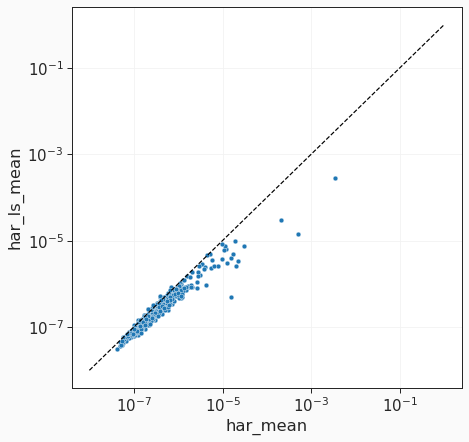

In [109]:
plt.figure(figsize = (7,7))
sns.scatterplot(x = 'har_mean', y = 'har_ls_mean', data = results_df)
plt.plot([1e-8, 1], [1e-8, 1], color = 'k', ls = 'dashed')
plt.yscale('log')
plt.xscale('log')
# plt.ylim(3e-8, 1e-5)
# plt.xlim(3e-8, 1e-5)


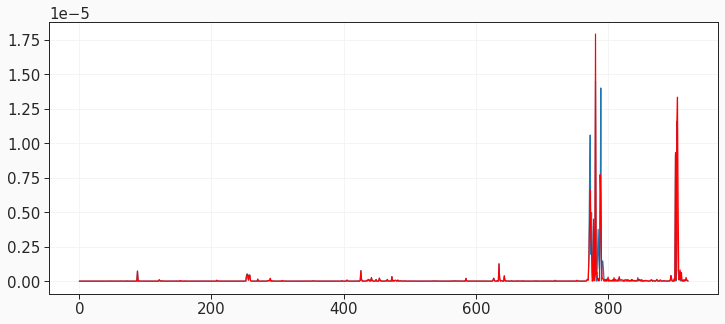

In [110]:
plt.figure(figsize = (12,5))
plt.plot(results_df.query('ticker == "AAPL"')['har_fer'].iloc[0])
plt.plot(results_df.query('ticker == "AAPL"')['har_ls_fer'].iloc[0], color = 'red', )


In [78]:
ticker_list = results_df['ticker'].unique()

def db_reg(ticker, reg_name):

        Y = results_df.query('ticker == @ticker')['har_vs_' + reg_name + '_Y'].iloc[0]
        m = len(Y)
        hac_lags = int(0.75*(m**(1/3)))
        fit = sm.OLS(Y, np.ones(m)).fit(cov_type = 'HAC', cov_kwds = {'maxlags': hac_lags})

        return fit

def temp_f(reg_name):

    if reg_name == 'har':
        return reg_name, None
        
    results = [] 
    
    for ticker in ticker_list:
        fit = db_reg(ticker, reg_name)
        results.append(fit.tvalues[0])
    
    return reg_name, results

with Pool(8) as p:
    for reg_name, results in tqdm(p.map(temp_f, reg_names), total = len(reg_names)):
        if results:
            print(reg_name)
            print(f'HAR Better (sig): {np.mean(np.array(results) < -1.96):.4%}')
            print(f'HAR Worse (sig): {np.mean(np.array(results) > 1.96):.4%}')
            print(f'HAR Worse (avg): {np.mean(np.array(results) > 0):.4%}')
            print()

simple
HAR Better (sig): 0.0000%
HAR Worse (sig): 0.0000%
HAR Worse (avg): 83.6518%

harq
HAR Better (sig): 0.0000%
HAR Worse (sig): 0.0000%
HAR Worse (avg): 21.8684%

har_posneg_j2_1
HAR Better (sig): 0.8493%
HAR Worse (sig): 0.0000%
HAR Worse (avg): 56.4756%

har_posneg_sgn_1
HAR Better (sig): 0.4246%
HAR Worse (sig): 0.0000%
HAR Worse (avg): 53.7155%

har_ls
HAR Better (sig): 0.0000%
HAR Worse (sig): 0.0000%
HAR Worse (avg): 93.6306%

har_ls_extend
HAR Better (sig): 1.4862%
HAR Worse (sig): 0.0000%
HAR Worse (avg): 66.4544%




# In-Sample Analysis

## Full sample estimation of LS model

In [ ]:
reg_formula_har = 'rv ~ rv_lag_1 + rv_lag_m5 + rv_lag_m22'

reg_formula_har_ls = ''' rv ~
switchn_lag_1
+ rv_lag_1 + rv_lag_1:switchn_lag_1 + 
rv_lag_m5:switchn_lag_1 + rv_lag_m22:switchn_lag_1
'''

In [ ]:
smf.ols(reg_formula_har, data_rv_df).fit().summary()

In [ ]:
smf.ols(reg_formula_har_ls, data_rv_df).fit().summary()

In [ ]:
ticker_list = data_rv_df['ticker'].unique()
results = []

def get_har_ls_params(ticker):

    fit = smf.ols(reg_formula_har_ls, data_rv_df.query('ticker == @ticker')).fit()
    result = fit.params[2:]
    result.index = ['harls_coeff_' + x for x in result.index]
    result['ticker'] = ticker
    result['rsquared_har_ls'] = fit.rsquared
    result['aic_har_ls'] = fit.aic
    
    fit = smf.ols(reg_formula_har, data_rv_df.query('ticker == @ticker')).fit()
    temp = fit.params[1:]
    temp.index = ['har_coeff_' + x for x in temp.index]
    result = result.append(temp)
    result['rsquared_har'] = fit.rsquared
    result['aic_har'] = fit.aic
    
    return result

with Pool(8) as p:
    
    for result in tqdm(p.imap_unordered(get_har_ls_params, ticker_list), total = len(ticker_list)):

        results.append(result)

In [ ]:
results_df = pd.DataFrame(results).set_index('ticker')
results_df.head()

## Distribution of HAR-LS Coefficients

In [ ]:
reg_cols = [x for x in results_df.columns if "harls_coeff_" in x]
reg_col_names = [
    "Coefficient on $RV_{t-1}^{(d)}$",
    "Coefficient on $RV_{t-1}^{(d)} \\times (1-CrisisIndex)$",
    "Coefficient on $RV_{t-1}^{(w)} \\times (1-CrisisIndex)$",
    "Coefficient on $RV_{t-1}^{(m)} \\times (1-CrisisIndex)$",
]

fig, axs = plt.subplots(figsize=(12, 6), nrows=2, ncols=2)
pal = sns.color_palette("Set2", 4)

for i in range(len(reg_cols)):

    col = reg_cols[i]
    ax = axs.reshape(-1)[i]
    if i == 1:
        ax.text(
            0.2, 0.75,
            f"{np.mean(results_df[col]<0):0.2%}\n Below Zero",
            ha="center",
            va="center",
            transform=ax.transAxes,
        )

    ax.hist(results_df[col], color=pal[i], bins=30, density = True)
    ax.axvline(0, 0, 1, color="k", ls="dashed", lw=2)
    ax.set_title(reg_col_names[i])

plt.tight_layout()

In [ ]:
reg_cols = [x for x in results_df.columns if "har_coeff_" in x]
reg_col_names = [
    "Coefficient on $RV_{t-1}^{(d)}$",
    "",
    "Coefficient on $RV_{t-1}^{(w)}$",
    "Coefficient on $RV_{t-1}^{(m)}$",
]

fig, axs = plt.subplots(figsize=(12, 6), nrows=2, ncols=2)
grid = plt.GridSpec(2, 2)
pal = sns.color_palette("Set2", 4)

for i in range(len(reg_cols)):

    col = reg_cols[i]
    
    if i == 0: 
        ax = plt.subplot(grid[0,:])
    else:
        i = i + 1
        ax = axs.reshape(-1)[i]

    ax.hist(results_df[col], color=pal[i], bins=30, density = True)
    ax.axvline(0, 0, 1, color="k", ls="dashed", lw=2)
    ax.set_title(reg_col_names[i])

plt.tight_layout()

## Distribution of R2

In [ ]:
r2_perf = np.mean(results_df['rsquared_har'] < results_df['rsquared_har_ls'])
aic_perf = np.mean(results_df['aic_har'] > results_df['aic_har_ls'])

In [ ]:
fig, axs = plt.subplots(figsize=(12, 5), ncols=2)

ax = axs[0]
sns.scatterplot(x="rsquared_har", y="rsquared_har_ls", data=results_df, ax=ax)
ax.plot([0, 1], [0, 1], color="k", ls="dashed")
ax.text(
    0.3,
    0.85,
    f"HAR-LS has higher \n$R^2$ for {r2_perf:0.2%} Stocks",
    fontsize=14,
    ha="center",
    va="center",
    transform=ax.transAxes
)

ax = axs[1]
sns.scatterplot(x="aic_har", y="aic_har_ls", data=results_df, ax=ax)
ax.plot([0, 1], [0, 1], color="k", ls="dashed", transform=ax.transAxes)
ax.text(
    0.3,
    0.85,
    f"HAR-LS has lower \nAIC for {aic_perf:0.2%} Stocks",
    fontsize=14,
    ha="center",
    va="center",
    transform=ax.transAxes
)


plt.tight_layout()

## Movement of AR Components

In [ ]:
reg_cols = [x for x in results_df.columns if "harls_coeff_" in x]

In [ ]:
merged_df = data_rv_df.merge(results_df, on = 'ticker', how  ='left')

In [ ]:
reg_switch_cols = [
    x for x in results_df.columns if "harls_coeff_" in x and "switch" in x
]

merged_df["harls_persistence"] = merged_df["harls_coeff_rv_lag_1"] + merged_df[
    "switchn_lag_1"
] * merged_df[reg_switch_cols].sum(axis=1)

merged_df["harls_beta_1"] = merged_df["harls_coeff_rv_lag_1"] + merged_df[
    "switchn_lag_1"
] * merged_df['harls_coeff_rv_lag_1:switchn_lag_1']

In [ ]:
plt.figure(figsize = (12,5))
ticker = 'GS'
sns.lineplot(x = 'date', y = 'harls_persistence', data = merged_df.query('ticker == @ticker'))
sns.lineplot(x = 'date', y = 'persistence', data = merged_df.query('ticker == @ticker'))

### AR (1)

In [ ]:
def fit_rolling_regression(ticker):

    reg_df = (
        data_rv_df.query("ticker == @ticker")
        .sort_values(by="date")[["date"] + var_list]
        .dropna()
        .set_index('date')
    )
    fit = RollingOLS.from_formula(reg_formula, reg_df, window).fit(
        method="pinv", params_only=True
    )

    fit_params_df = fit.params
    fit_params_df["ticker"] = ticker

    return fit_params_df.reset_index()

%%time
# Run HARs
tickers = data_rv_df[
    "ticker"
].unique()  
results = []

with Pool(8) as p:
    for fit_params_df in tqdm(
        p.imap_unordered(fit_rolling_regression, tickers, chunksize=30),
        total=len(tickers),
    ):
        results.append(fit_params_df)

rolling_ar1_df = pd.concat(results)

#### First Set

In [ ]:
# Window length
window = 66

# Regression
reg_formula = 'rv ~ rv_lag_1'
var_list = reg_formula.replace('+', ' ').replace('~', ' ').split()

# Implied AR(1) coefficient estimate
fig, axs = plt.subplots(figsize=(12, 8), nrows = 3)
ticker_list = ["AMZN", 'AAPL', 'MRK']

merged_df["harls_AR1"] = merged_df["harls_coeff_rv_lag_1"] + merged_df[
    "switchn_lag_1"
] * (
    merged_df["harls_coeff_rv_lag_1:switchn_lag_1"]
    + merged_df["harls_coeff_rv_lag_m5:switchn_lag_1"] / 5
    + merged_df["harls_coeff_rv_lag_m22:switchn_lag_1"] / 22
)

merged_df["rollcoef_AR1"] = (
    merged_df["rv_lag_1_rollcoeff"]
    + merged_df["rv_lag_m5_rollcoeff"] / 5
    + merged_df["rv_lag_m22_rollcoeff"] / 22
)

ax = axs[0]
for i in range(len(ticker_list)):
    ax = axs.reshape(-1)[i]
    ticker = ticker_list[i]
    sns.lineplot(
        x="date",
        y="rv_lag_1",
        label="Rolling Autocorrelation",
        color="k",
        alpha=0.8,
        data=rolling_ar1_df.query("ticker == @ticker"),
        ax = ax
    )
    sns.lineplot(
        x="date",
        y="harls_AR1",
        lw=2,
        label="HAR-LS Estimate",
        data=merged_df.query("ticker == @ticker"),
        ax = ax
    )
    ax.set_xlabel('')
    ax.set_ylabel("AR(1) Coefficient \n for RV", fontsize = 14)
    ax.set_title('$' + ticker)
    if i > 0:
        ax.get_legend().remove()
    
plt.tight_layout()

#### First Set

In [ ]:
# Implied AR(1) coefficient estimate

fig, axs = plt.subplots(figsize=(12, 8), nrows = 3)
ticker_list = ["BSX", 'MHK', 'KR']

merged_df["harls_AR1"] = merged_df["harls_coeff_rv_lag_1"] + merged_df[
    "switchn_lag_1"
] * (
    merged_df["harls_coeff_rv_lag_1:switchn_lag_1"]
    + merged_df["harls_coeff_rv_lag_m5:switchn_lag_1"] / 5
    + merged_df["harls_coeff_rv_lag_m22:switchn_lag_1"] / 22
)

merged_df["rollcoef_AR1"] = (
    merged_df["rv_lag_1_rollcoeff"]
    + merged_df["rv_lag_m5_rollcoeff"] / 5
    + merged_df["rv_lag_m22_rollcoeff"] / 22
)

ax = axs[0]
for i in range(len(ticker_list)):
    ax = axs.reshape(-1)[i]
    ticker = ticker_list[i]
    sns.lineplot(
        x="date",
        y="rv_lag_1",
        label="Rolling Autocorrelation",
        color="k",
        alpha=0.8,
        data=rolling_ar1_df.query("ticker == @ticker"),
        ax = ax
    )
    sns.lineplot(
        x="date",
        y="harls_AR1",
        lw=2,
        label="HAR-LS Estimate",
        data=merged_df.query("ticker == @ticker"),
        ax = ax
    )
    ax.set_xlabel('')
    ax.set_ylabel("AR(1) Coefficient \n for RV", fontsize = 14)
    ax.set_title('$' + ticker)
    if i > 0:
        ax.get_legend().remove()
    
plt.tight_layout()